# Bytes List

This notebook demonstrates the training and evaluation of a neural network designed to convert lists of bytes (bit representations) into their corresponding integer values. 

The experiment explores two training approaches: supervised learning, where the network learns directly from input-output pairs, and fitness-based learning, where the network is trained using a fitness function based on output accuracy.

The notebook covers data generation, neural network construction, training, and performance evaluation, providing insights into how neural networks can learn to interpret binary data.

## Code Implementation

### Importing the Neural Network Library

First, we need to import the necessary classes from the `neural_network` library to construct the neural network.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from neural_network.layer import HiddenLayer, InputLayer, OutputLayer
from neural_network.math.activation_functions import LinearActivation, SigmoidActivation
from neural_network.math.learning_rate_scheduler import ExponentialDecayScheduler
from neural_network.math.optimizer import AdamOptimizer, Optimizer, SGDOptimizer
from neural_network.neural_network import NeuralNetwork

logging.basicConfig(format="%(asctime)s %(message)s", datefmt="[%d-%m-%Y|%H:%M:%S]", level=logging.INFO)
logger = logging.getLogger(__name__)
rng = np.random.default_rng()

The following parameters are required to define the architecture of the neural network. The number of inputs is `NUM_BITS`, and the number of outputs is 1.

The number of data points to use for training and testing is given by `DATASET_SIZE`. This is split into training and testing datasets to introduce variety in the training and testing.

In [2]:
# Neural network parameters
HIDDEN_LAYER_SIZES = [4]
INPUT_ACTIVATION = LinearActivation
HIDDEN_ACTIVATION = SigmoidActivation
OUTPUT_ACTIVATION = SigmoidActivation
WEIGHTS_RANGE = (-1, 1)
BIAS_RANGE = (-0.3, 0.3)
LR_SCHEDULER = ExponentialDecayScheduler(decay_steps=1000, decay_rate=0.9)
SUPERVISED_OPTIMIZER = AdamOptimizer(lr=0.01, lr_scheduler=LR_SCHEDULER, beta1=0.9, beta2=0.999, epsilon=1e-08)
FITNESS_OPTIMIZER = SGDOptimizer(lr=0.02, lr_scheduler=LR_SCHEDULER)
SMOOTHING_ALPHA = 0.25

# Dataset parameters
DATASET_SIZE = 300
TRAIN_SIZE_RATIO = 0.8
NUM_EPOCHS = 20

# Bytes lists parameters
NUM_BITS = 8
IN_LIMS = [0, 255]
OUT_LIMS = [0, 1]

### Creating Methods to Generate Training Data


We will be using 8-bit numbers to train the neural network.
The following functions will allow us to convert between between integers and bytes lists.
We can use those functions to create the training and testing datasets.
We will select random numbers and train the neural network with the corresponding byte lists and expected outputs.


In [3]:
def num_to_byte_list(num: int) -> list[int]:
    """Convert a number to a list of bits.

    :param int num:
        Number to convert.
    :return list[int]:
        Number represented as list of bits.
    """
    _num_bin = bin(num)
    _num_bytes = _num_bin[2:]
    _padding = [0] * (NUM_BITS - len(_num_bytes))
    return _padding + [int(b) for b in _num_bytes]


def map_val(x: float, in_min: float, in_max: float, out_min: float, out_max: float) -> float:
    """Map a value from an input range to an output range.

    :param float x:
        Number to map to new range.
    :param float in_min:
        Lower bound of original range.
    :param float in_max:
        Upper bound of original range.
    :param float out_min:
        Lower bound of new range.
    :param float out_max:
        Upper bound of new range.
    :return float:
        Number mapped to new range.
    """
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min


def training_data_from_num(num: int) -> tuple[list[int], float]:
    """Generate byte list and mapped number from a number to use in training.

    :param int num:
        Number to use for training data.
    :return tuple[list[int], float]:
        Input and expected output.
    """
    _byte_list = np.array(num_to_byte_list(num))
    _mapped_num = map_val(num, IN_LIMS[0], IN_LIMS[1], OUT_LIMS[0], OUT_LIMS[1])
    return (_byte_list, _mapped_num)


def split_data(data: list, train_size_ratio: float = TRAIN_SIZE_RATIO) -> tuple[list, list]:
    """Split the dataset into training and testing sets.

    :param list[tuple[list[int], float]] data:
        The dataset to split.
    :param float train_size_ratio:
        The proportion of the dataset to include in the training split.
    :return tuple[list[tuple[list[int], float]], list[tuple[list[int], float]]]:
        Training and testing datasets.
    """
    train_size = int(len(data) * train_size_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def calculate_errors(expected_outputs: np.ndarray, actual_outputs: np.ndarray) -> np.ndarray:
    """Calculate the error between expected and actual outputs.

    :param np.ndarray expected_outputs:
        The expected output values.
    :param np.ndarray actual_outputs:
        The actual output values.
    :return np.ndarray:
        The calculated errors.
    """
    return expected_outputs - actual_outputs


def calculate_percentage_error(errors: np.ndarray) -> float:
    """Calculate the percentage error from a list of errors.

    :param np.ndarray errors:
        The list of errors.
    :return float:
        The average error as a percentage.
    """
    avg_error = np.average(np.abs(errors))
    return avg_error / (OUT_LIMS[1] - OUT_LIMS[0]) * 100

### Dataset Creation

The supervised learning approach uses expected outputs against given inputs to backpropagate errors.
In the fitness-based approach, we need to calculate the fitness value for each output against given inputs, and use that to calculate the errors.

In [4]:
# Supervised training
def generate_supervised_training_data(dataset_size: int) -> list[tuple[list[int], float]]:
    """Generate supervised training data for the neural network.

    :param int dataset_size:
        Number of samples to generate.
    :return list[tuple[list[int], float]]:
        Input and expected output pairs.
    """
    random_num = rng.integers(low=IN_LIMS[0], high=(IN_LIMS[1] + 1), size=dataset_size)
    return [training_data_from_num(num) for num in random_num]


# Fitness training
def calculate_fitness(expected_output: float, nn_output: float) -> float:
    """Calculate fitness based on the accuracy of the neural network's output.

    :param float expected_output:
        The correct output value.
    :param float nn_output:
        The neural network's predicted output.
    :return float:
        A fitness value where higher is better.
    """
    error = np.abs(expected_output - nn_output)
    return np.exp(-error * 8)


def generate_fitness_training_data(dataset_size: int, nn: NeuralNetwork) -> list[tuple[list[int], list[float], float]]:
    """Generate fitness training data for the neural network.

    :param int dataset_size:
        Number of samples to generate.
    :param NeuralNetwork nn:
        Neural network to evaluate outputs.
    :return list[tuple[list[int], list[float], float]]:
        Input, output and fitness values.
    """
    data = generate_supervised_training_data(dataset_size)
    nn_outputs = [nn.feedforward(input_data) for input_data, _ in data]
    return [
        (input_data, nn_output, calculate_fitness(expected_output, nn_output))
        for (input_data, expected_output), nn_output in zip(data, nn_outputs, strict=False)
    ]

### Neural Network Creation

The following functions are used to create and test neural networks using the parameters defined earlier in this notebook.

In [5]:
def create_nn(
    input_size: int = NUM_BITS,
    hidden_layer_sizes: list[int] = HIDDEN_LAYER_SIZES,
    input_activation: type = INPUT_ACTIVATION,
    hidden_activation: type = HIDDEN_ACTIVATION,
    output_activation: type = OUTPUT_ACTIVATION,
    weights_range: tuple[float, float] = WEIGHTS_RANGE,
    bias_range: tuple[float, float] = BIAS_RANGE,
    optimizer: Optimizer = SUPERVISED_OPTIMIZER,
) -> NeuralNetwork:
    """Create a neural network with specified parameters.

    :param int input_size:
        Number of input nodes.
    :param list[int] hidden_layer_sizes:
        Sizes of hidden layers.
    :param type input_activation:
        Activation function for input layer.
    :param type hidden_activation:
        Activation function for hidden layers.
    :param type output_activation:
        Activation function for output layer.
    :param tuple[float, float] weights_range:
        Range for initializing weights.
    :param tuple[float, float] bias_range:
        Range for initializing biases.
    :param Optimizer optimizer:
        Optimizer to use for training the neural network.
    :return NeuralNetwork:
        Constructed neural network.
    """
    input_layer = InputLayer(size=input_size, activation=input_activation)
    hidden_layers = [
        HiddenLayer(size=size, activation=hidden_activation, weights_range=weights_range, bias_range=bias_range)
        for size in hidden_layer_sizes
    ]
    output_layer = OutputLayer(size=1, activation=output_activation, weights_range=weights_range, bias_range=bias_range)

    return NeuralNetwork.from_layers(layers=[input_layer, *hidden_layers, output_layer], optimizer=optimizer)


def evaluate_nn(nn: NeuralNetwork, data: list[tuple[list[int], float]]) -> tuple[float, float]:
    """Evaluate the neural network on a dataset.

    :param NeuralNetwork nn:
        The neural network to evaluate.
    :param list[tuple[list[int], float]] data:
        The dataset to evaluate on.
    :return tuple[np.ndarray, float]:
        List of errors and average error as a percentage.
    """
    dataset_size = len(data)
    outputs = []
    for i in range(dataset_size):
        inputs = data[i][0]
        output = nn.feedforward(inputs)[0]
        outputs.append(output)

    errors = calculate_errors(
        expected_outputs=np.array([data[i][1] for i in range(dataset_size)]), actual_outputs=np.array(outputs)
    )
    percentage_error = calculate_percentage_error(errors)
    return errors, percentage_error

### Running the Algorithm

Now we can run the training algorithm and test the neural network to evaluate its accuracy.
First, we will use the supervised learning approach:

In [6]:
logger.info("Creating neural network for supervised training...")
nn_supervised = create_nn()
logger.info("Generating supervised training data with %s data points...", DATASET_SIZE)
data_supervised = generate_supervised_training_data(DATASET_SIZE)
training_data_supervised, testing_data_supervised = split_data(data_supervised)
logger.info("Training neural network with %s data points for %s epochs...", len(training_data_supervised), NUM_EPOCHS)
nn_supervised.run_supervised_training(
    inputs=[input_data for input_data, _ in training_data_supervised],
    expected_outputs=[expected_output for _, expected_output in training_data_supervised],
    epochs=NUM_EPOCHS,
)

logger.info("Testing neural network with %s data points...", len(testing_data_supervised))
errors, percentage_error = evaluate_nn(nn_supervised, testing_data_supervised)
avg_error = np.average(errors)
logger.info("Average error: %.4f", avg_error)
logger.info("Supervised training percentage error: %.4f%%", percentage_error)

[29-06-2025|20:22:30] Creating neural network for supervised training...
[29-06-2025|20:22:30] Generating supervised training data with 300 data points...
[29-06-2025|20:22:30] Training neural network with 240 data points for 20 epochs...
[29-06-2025|20:22:31] Testing neural network with 60 data points...
[29-06-2025|20:22:31] Average error: 0.0042
[29-06-2025|20:22:31] Supervised training percentage error: 2.8968%


Now for the fitness-based approach:

In [7]:
logger.info("Creating neural network for fitness training...")
nn_fitness = create_nn(optimizer=FITNESS_OPTIMIZER)
logger.info("Generating fitness training data with %s data points...", DATASET_SIZE)
data_fitness = generate_fitness_training_data(DATASET_SIZE, nn_fitness)
training_data_fitness, testing_data_fitness = split_data(data_fitness)
logger.info("Training neural network with %s data points...", len(training_data_fitness))
nn_fitness.run_fitness_training(
    inputs=[input_data for input_data, _, _ in training_data_fitness],
    outputs=[output for _, output, _ in training_data_fitness],
    fitnesses=[fitness for _, _, fitness in training_data_fitness],
    epochs=NUM_EPOCHS,
    alpha=SMOOTHING_ALPHA,
)

logger.info("Testing neural network with %s data points...", len(testing_data_fitness))
errors_fitness, percentage_error_fitness = evaluate_nn(nn_fitness, testing_data_fitness)
avg_error_fitness = np.average(errors_fitness)
logger.info("Average error: %.4f", avg_error_fitness)
logger.info("Fitness training percentage error: %.4f%%", percentage_error_fitness)

[29-06-2025|20:22:31] Creating neural network for fitness training...
[29-06-2025|20:22:31] Generating fitness training data with 300 data points...
[29-06-2025|20:22:31] Training neural network with 240 data points...
[29-06-2025|20:22:31] Testing neural network with 60 data points...
[29-06-2025|20:22:31] Average error: -0.0025
[29-06-2025|20:22:31] Fitness training percentage error: 6.2431%


### Results Visualization

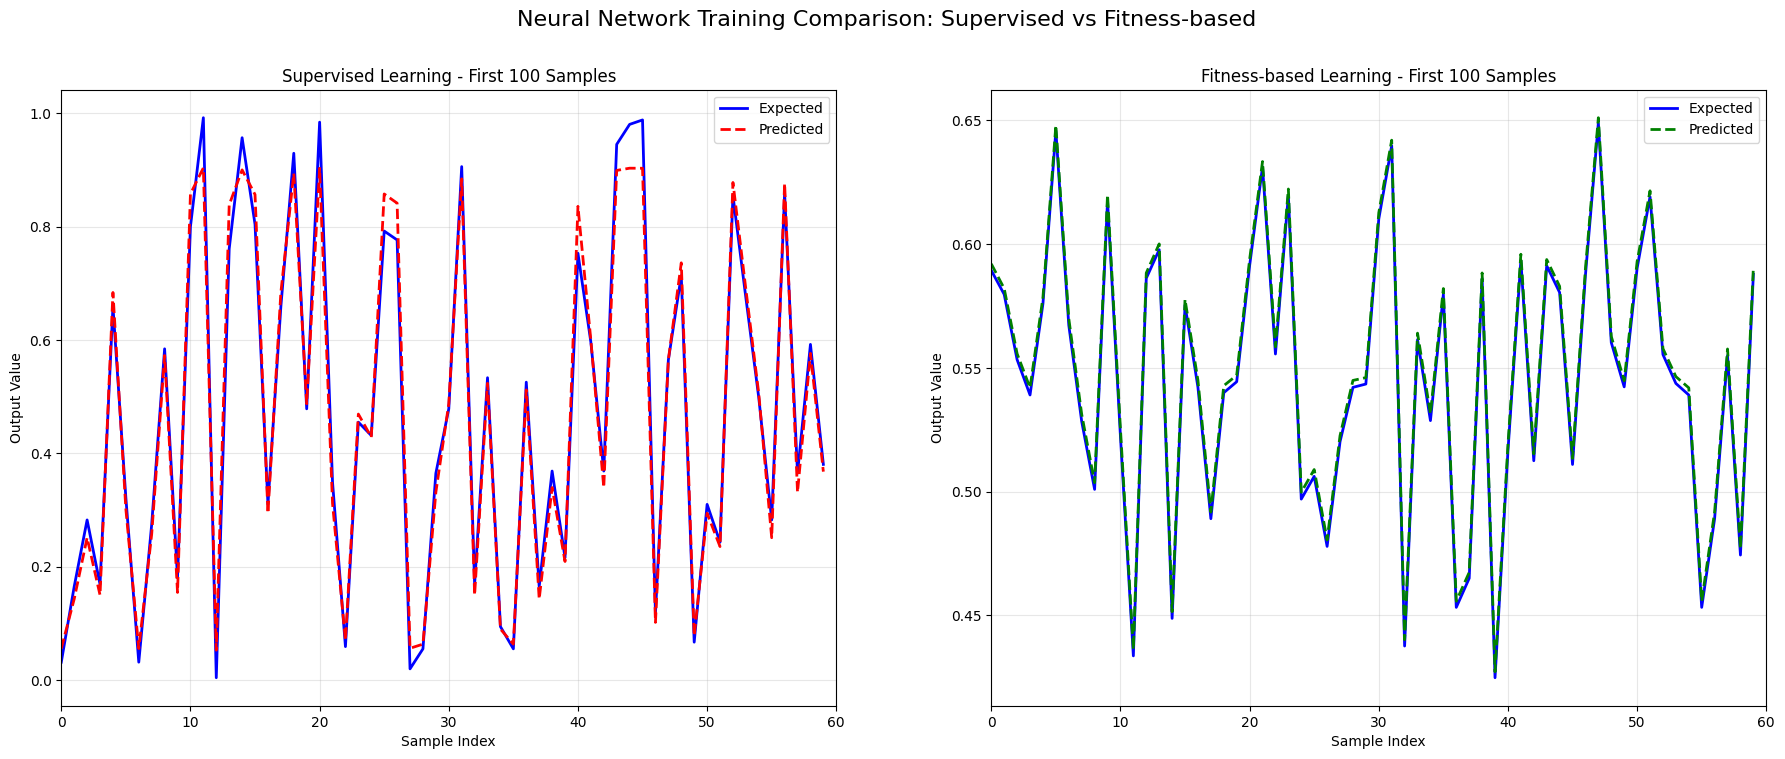

[29-06-2025|20:23:17] === SUMMARY STATISTICS ===
[29-06-2025|20:23:17] Supervised Learning:
[29-06-2025|20:23:17]   - Average Error: 0.0042
[29-06-2025|20:23:17]   - Percentage Error: 2.8968%
[29-06-2025|20:23:17]   - Standard Deviation of Errors: 0.0369
[29-06-2025|20:23:17] Fitness-based Learning:
[29-06-2025|20:23:17]   - Average Error: -0.0025
[29-06-2025|20:23:17]   - Percentage Error: 6.2431%
[29-06-2025|20:23:17]   - Standard Deviation of Errors: 0.0779


In [9]:
# Extract testing data for visualization
test_inputs_supervised = [input_data for input_data, _ in testing_data_supervised]
test_expected_supervised = [expected_output for _, expected_output in testing_data_supervised]
test_predicted_supervised = [nn_supervised.feedforward(input_data)[0] for input_data in test_inputs_supervised]

test_inputs_fitness = [input_data for input_data, _, _ in testing_data_fitness]
test_expected_fitness = [expected_output for _, expected_output, _ in testing_data_fitness]
test_predicted_fitness = [nn_fitness.feedforward(input_data)[0] for input_data in test_inputs_fitness]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle("Neural Network Training Comparison: Supervised vs Fitness-based", fontsize=16)

# Plot 1: Expected vs Predicted for Supervised Learning
sample_indices = range(min(100, len(test_expected_supervised)))
axes[0].plot(sample_indices, [test_expected_supervised[i] for i in sample_indices], "b-", label="Expected", linewidth=2)
axes[0].plot(
    sample_indices, [test_predicted_supervised[i] for i in sample_indices], "r--", label="Predicted", linewidth=2
)
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Output Value")
axes[0].set_title("Supervised Learning - First 100 Samples")
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 60)

# Plot 2: Expected vs Predicted for Fitness-based Learning
axes[1].plot(sample_indices, [test_expected_fitness[i] for i in sample_indices], "b-", label="Expected", linewidth=2)
axes[1].plot(sample_indices, [test_predicted_fitness[i] for i in sample_indices], "g--", label="Predicted", linewidth=2)
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Output Value")
axes[1].set_title("Fitness-based Learning - First 100 Samples")
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, 60)

plt.show()

# Print summary statistics
logger.info("=== SUMMARY STATISTICS ===")
logger.info("Supervised Learning:")
logger.info("  - Average Error: %.4f", avg_error)
logger.info("  - Percentage Error: %.4f%%", percentage_error)
logger.info("  - Standard Deviation of Errors: %.4f", np.std(errors))

logger.info("Fitness-based Learning:")
logger.info("  - Average Error: %.4f", avg_error_fitness)
logger.info("  - Percentage Error: %.4f%%", percentage_error_fitness)
logger.info("  - Standard Deviation of Errors: %.4f", np.std(errors_fitness))